In [28]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [29]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../../../Dataset/FFIV_Stock.csv')
df

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,3/1/2019,FFIV,166.529999,166.529999,168.330002,165.419998,167.600006,756400
1,3/4/2019,FFIV,163.289993,163.289993,167.289993,161.710007,166.970001,553700
2,3/5/2019,FFIV,162.149994,162.149994,163.399994,161.970001,163.240005,511300
3,3/6/2019,FFIV,161.080002,161.080002,162.139999,159.949997,161.919998,527000
4,3/7/2019,FFIV,158.990005,158.990005,161.250000,157.910004,160.630005,783200
...,...,...,...,...,...,...,...,...
1319,5/28/2024,FFIV,168.339996,168.339996,170.000000,167.339996,169.119995,497000
1320,5/29/2024,FFIV,168.229996,168.229996,170.509995,166.550003,167.080002,655200
1321,5/30/2024,FFIV,167.300003,167.300003,168.669998,166.130005,168.309998,401100
1322,5/31/2024,FFIV,168.970001,168.970001,169.130005,164.580002,166.479996,1137700


In [30]:
df.describe

<bound method NDFrame.describe of            Date Symbol   Adj Close       Close        High         Low  \
0      3/1/2019   FFIV  166.529999  166.529999  168.330002  165.419998   
1      3/4/2019   FFIV  163.289993  163.289993  167.289993  161.710007   
2      3/5/2019   FFIV  162.149994  162.149994  163.399994  161.970001   
3      3/6/2019   FFIV  161.080002  161.080002  162.139999  159.949997   
4      3/7/2019   FFIV  158.990005  158.990005  161.250000  157.910004   
...         ...    ...         ...         ...         ...         ...   
1319  5/28/2024   FFIV  168.339996  168.339996  170.000000  167.339996   
1320  5/29/2024   FFIV  168.229996  168.229996  170.509995  166.550003   
1321  5/30/2024   FFIV  167.300003  167.300003  168.669998  166.130005   
1322  5/31/2024   FFIV  168.970001  168.970001  169.130005  164.580002   
1323   6/3/2024   FFIV  166.910004  166.910004  169.679993  166.320007   

            Open   Volume  
0     167.600006   756400  
1     166.970001   55

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1324 non-null   object 
 1   Symbol     1324 non-null   object 
 2   Adj Close  1324 non-null   float64
 3   Close      1324 non-null   float64
 4   High       1324 non-null   float64
 5   Low        1324 non-null   float64
 6   Open       1324 non-null   float64
 7   Volume     1324 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 82.9+ KB


In [32]:
def detect_outlier(df, col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(df[(df[col] < lower_bound) | (df[col] > upper_bound)])

In [33]:
detect_outlier(df, 'Close')

Empty DataFrame
Columns: [Date, Symbol, Adj Close, Close, High, Low, Open, Volume]
Index: []


In [34]:
df1=df.reset_index()['Close']

In [35]:
df1

0       166.529999
1       163.289993
2       162.149994
3       161.080002
4       158.990005
           ...    
1319    168.339996
1320    168.229996
1321    167.300003
1322    168.970001
1323    166.910004
Name: Close, Length: 1324, dtype: float64

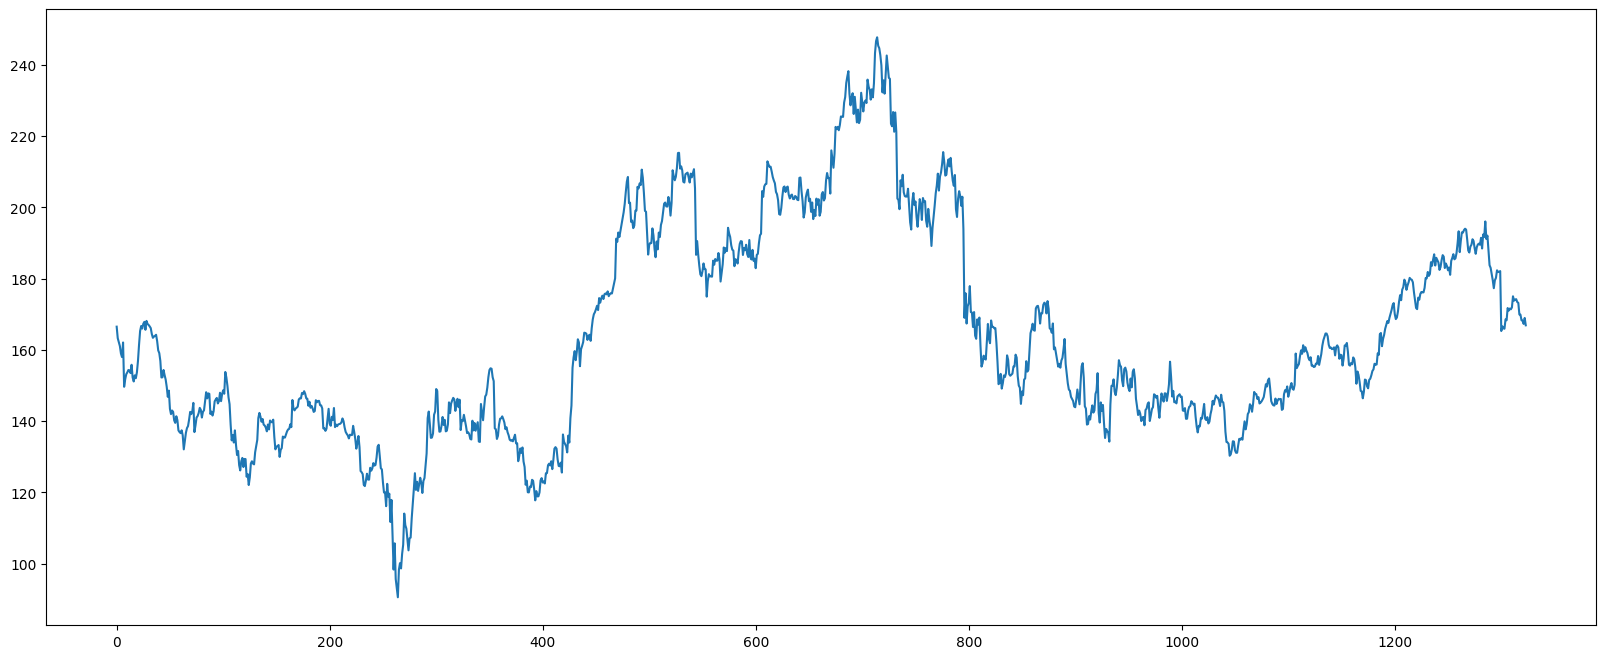

In [36]:
plt.figure(figsize=(20, 8))
plt.plot(df1)
plt.show()

In [37]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [38]:
df1

array([[0.4832411 ],
       [0.46263431],
       [0.45538379],
       ...,
       [0.48813841],
       [0.49875978],
       [0.48565797]])

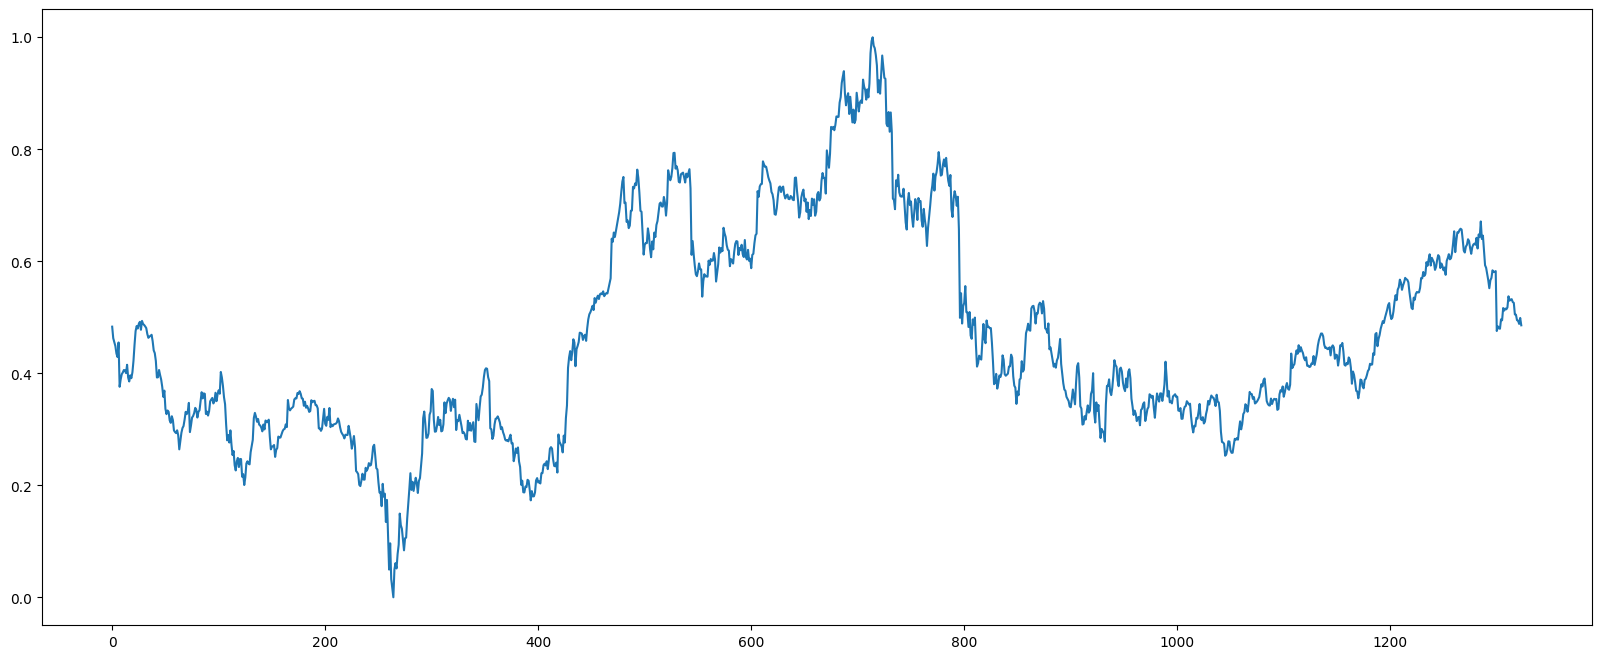

In [39]:
plt.figure(figsize=(20, 8))
plt.plot(df1)
plt.show()

In [40]:
# 4. Chia train test
train_size = int(0.75 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [41]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [42]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [43]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [44]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


14/14 [==============================] - 10s 125ms/step - loss: 0.1184 - val_loss: 0.0024
Epoch 2/100
14/14 [==============================] - 1s 76ms/step - loss: 0.0179 - val_loss: 0.0054
Epoch 3/100
14/14 [==============================] - 1s 65ms/step - loss: 0.0096 - val_loss: 0.0027
Epoch 4/100
14/14 [==============================] - 1s 84ms/step - loss: 0.0071 - val_loss: 0.0012
Epoch 5/100
14/14 [==============================] - 1s 63ms/step - loss: 0.0050 - val_loss: 8.1076e-04
Epoch 6/100
14/14 [==============================] - 1s 76ms/step - loss: 0.0034 - val_loss: 5.9890e-04
Epoch 7/100
14/14 [==============================] - 1s 61ms/step - loss: 0.0023 - val_loss: 4.7426e-04
Epoch 8/100
14/14 [==============================] - 1s 57ms/step - loss: 0.0016 - val_loss: 4.0680e-04
Epoch 9/100
14/14 [==============================] - 1s 73ms/step - loss: 0.0012 - val_loss: 3.8934e-04
Epoch 10/100
14/14 [==============================] - 1s 65ms/step - loss: 0.0010 - val_lo

In [46]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

13/28 [============>.................] - ETA: 0s

8/8 [==============================] - 0s 14ms/step


In [47]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
# y_pred_val=scaler.inverse_transform(y_pred_val)

In [48]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#  Tính MAE
def calculate_mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

# Tính toán RMSE, MAPE và MDA
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mape = calculate_mape(ytest, y_pred)
test_mae = calculate_mae(ytest, y_pred)

# In kết quả
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 2.3497274678441604
Testing MAPE: 0.9889710345152418
Testing MAE: 1.6706458698242188


In [49]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])

from numpy import array

lst_output_30=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i=i+1


[0.48925018]
101
1 day input [0.5451886  0.54442532 0.54448898 0.55243912 0.57012022 0.56948417
 0.58093238 0.57387266 0.57737074 0.59842269 0.59199901 0.60306554
 0.61241491 0.59244417 0.60618203 0.60217513 0.5978503  0.58462126
 0.5898365  0.60217513 0.61095211 0.60809008 0.58799211 0.59600581
 0.59142653 0.58385808 0.58888252 0.57584428 0.60064876 0.60599123
 0.61266937 0.60351079 0.60529162 0.61483178 0.63232208 0.65350126
 0.61635824 0.63632898 0.65172044 0.65114795 0.65572724 0.65814411
 0.65655408 0.63893655 0.61915661 0.61565863 0.62621633 0.62952362
 0.63931824 0.63613819 0.62316351 0.61330532 0.62513513 0.62990521
 0.63149524 0.62952362 0.64186225 0.62284548 0.64790433 0.64326148
 0.67111879 0.63969983 0.64580548 0.61972909 0.59295299 0.5883737
 0.57717994 0.56630411 0.5519303  0.56604975 0.57037458 0.58385808
 0.58067802 0.58125041 0.58245885 0.47548176 0.48381348 0.4803155
 0.47948866 0.49627934 0.49462575 0.51650444 0.51192516 0.51561403
 0.5142148  0.51758565 0.53742926 0

In [50]:
# 13. Dự báo 60 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])

from numpy import array

lst_output_60=[]
n_steps=x_input.shape[1]
i=0
while(i<60):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1


[0.48925018]
101
1 day input [0.5451886  0.54442532 0.54448898 0.55243912 0.57012022 0.56948417
 0.58093238 0.57387266 0.57737074 0.59842269 0.59199901 0.60306554
 0.61241491 0.59244417 0.60618203 0.60217513 0.5978503  0.58462126
 0.5898365  0.60217513 0.61095211 0.60809008 0.58799211 0.59600581
 0.59142653 0.58385808 0.58888252 0.57584428 0.60064876 0.60599123
 0.61266937 0.60351079 0.60529162 0.61483178 0.63232208 0.65350126
 0.61635824 0.63632898 0.65172044 0.65114795 0.65572724 0.65814411
 0.65655408 0.63893655 0.61915661 0.61565863 0.62621633 0.62952362
 0.63931824 0.63613819 0.62316351 0.61330532 0.62513513 0.62990521
 0.63149524 0.62952362 0.64186225 0.62284548 0.64790433 0.64326148
 0.67111879 0.63969983 0.64580548 0.61972909 0.59295299 0.5883737
 0.57717994 0.56630411 0.5519303  0.56604975 0.57037458 0.58385808
 0.58067802 0.58125041 0.58245885 0.47548176 0.48381348 0.4803155
 0.47948866 0.49627934 0.49462575 0.51650444 0.51192516 0.51561403
 0.5142148  0.51758565 0.53742926 0

In [51]:
# 13. Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])


from numpy import array

lst_output_90=[]
n_steps=x_input.shape[1]
i=0
while(i<90):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1


[0.48925018]
101
1 day input [0.5451886  0.54442532 0.54448898 0.55243912 0.57012022 0.56948417
 0.58093238 0.57387266 0.57737074 0.59842269 0.59199901 0.60306554
 0.61241491 0.59244417 0.60618203 0.60217513 0.5978503  0.58462126
 0.5898365  0.60217513 0.61095211 0.60809008 0.58799211 0.59600581
 0.59142653 0.58385808 0.58888252 0.57584428 0.60064876 0.60599123
 0.61266937 0.60351079 0.60529162 0.61483178 0.63232208 0.65350126
 0.61635824 0.63632898 0.65172044 0.65114795 0.65572724 0.65814411
 0.65655408 0.63893655 0.61915661 0.61565863 0.62621633 0.62952362
 0.63931824 0.63613819 0.62316351 0.61330532 0.62513513 0.62990521
 0.63149524 0.62952362 0.64186225 0.62284548 0.64790433 0.64326148
 0.67111879 0.63969983 0.64580548 0.61972909 0.59295299 0.5883737
 0.57717994 0.56630411 0.5519303  0.56604975 0.57037458 0.58385808
 0.58067802 0.58125041 0.58245885 0.47548176 0.48381348 0.4803155
 0.47948866 0.49627934 0.49462575 0.51650444 0.51192516 0.51561403
 0.5142148  0.51758565 0.53742926 0

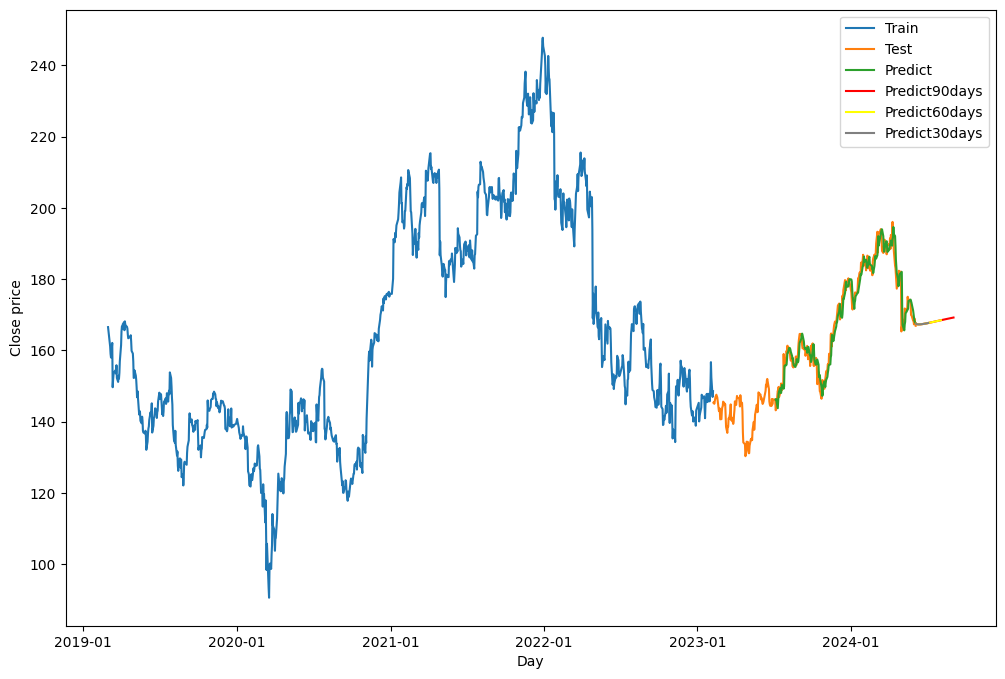

In [52]:
# 14.Vẽ hình
import matplotlib.dates as mdates
plt.figure(figsize=(12, 8))
df['Date'] = pd.to_datetime(df['Date'])
plt.plot(df['Date'][:train_size],scaler.inverse_transform(train_data))
plt.plot(df['Date'][train_size:],scaler.inverse_transform(test_data))
plt.plot(df['Date'][train_size+101:],(y_pred))
predict_data_index_90 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=30, freq='D')
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Close price')
plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.show()

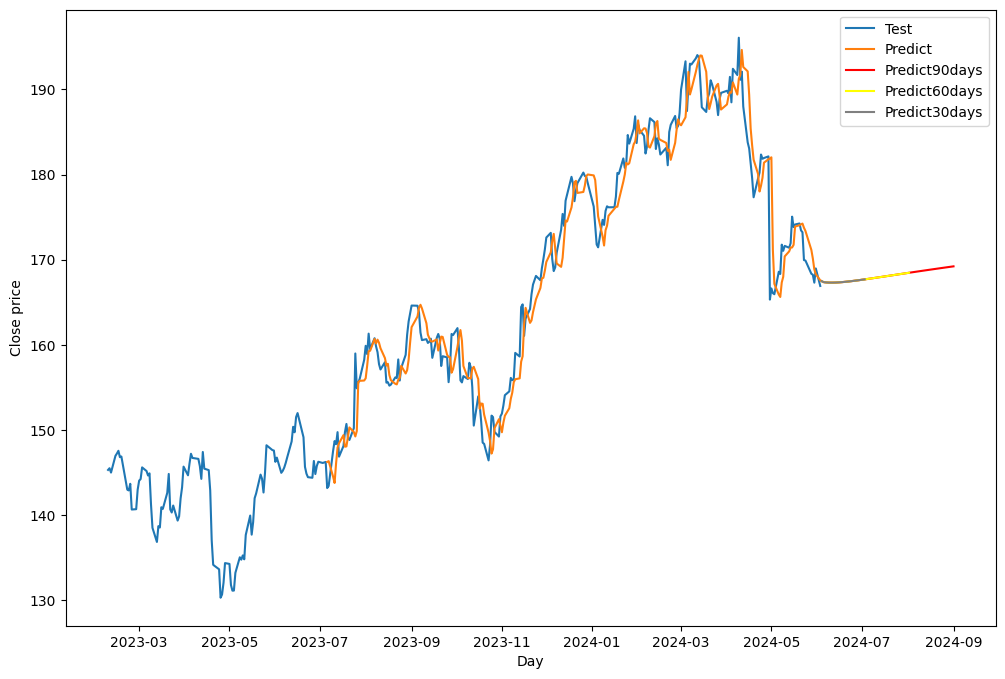

In [53]:
# 14.Vẽ hình test predict
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(12,8))
plt.plot(df['Date'][train_size:],scaler.inverse_transform(test_data))
plt.plot(df['Date'][train_size+101:],(y_pred))
predict_data_index_90 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=30, freq='D')
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Close price')
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.show()

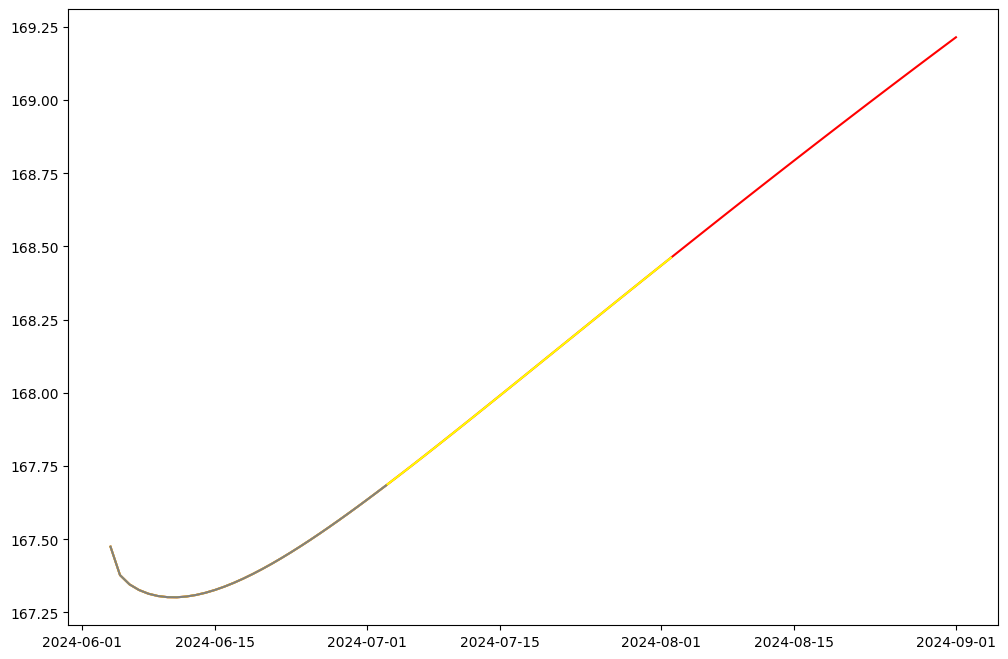

In [54]:
plt.figure(figsize=(12,8))
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.show()